In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("MPS is available:", torch.backends.mps.is_available())
print("MPS is built:", torch.backends.mps.is_built())

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

PyTorch version: 2.9.1
MPS is available: True
MPS is built: True
Using device: mps


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch

# CIFAR-10 클래스 이름
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# pt 파일 로드
data_file = Path('cifar10/stealing_set_SD_1.5/generated_data_resnet18_True.pt')
label_file = Path('cifar10/stealing_set_SD_1.5/generated_label_resnet18_True.pt')

print(f"Loading data from {data_file} and {label_file}")

data = torch.load(data_file, map_location='cpu')
labels = torch.load(label_file, map_location='cpu')

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Data type: {data.dtype}, Labels type: {labels.dtype}")

# 라벨이 원-핫 인코딩 형식이면 argmax로 클래스 인덱스로 변환
if labels.dim() > 1 and labels.shape[1] > 1:
    labels = torch.argmax(labels, dim=1)
    print(f"Converted one-hot labels to class indices. New shape: {labels.shape}")

# 클래스별 샘플 수
class_counts = {}
for label in labels:
    label_val = label.item() if hasattr(label, 'item') else int(label)
    class_counts[label_val] = class_counts.get(label_val, 0) + 1

print("\n클래스별 샘플 수:")
for class_id, count in sorted(class_counts.items()):
    class_name = CIFAR10_CLASSES[class_id] if class_id < len(CIFAR10_CLASSES) else f"Unknown({class_id})"
    print(f"  {class_id}: {class_name} - {count} samples")

Loading data from cifar10/stealing_set_SD_1.5/generated_data_resnet18_True.pt and cifar10/stealing_set_SD_1.5/generated_label_resnet18_True.pt
Data shape: torch.Size([35716, 3, 32, 32])
Labels shape: torch.Size([35716, 10])
Data type: torch.float32, Labels type: torch.float32
Converted one-hot labels to class indices. New shape: torch.Size([35716])

클래스별 샘플 수:
  0: airplane - 3931 samples
  1: automobile - 3515 samples
  2: bird - 4132 samples
  3: cat - 3585 samples
  4: deer - 3887 samples
  5: dog - 2975 samples
  6: frog - 3517 samples
  7: horse - 3187 samples
  8: ship - 3040 samples
  9: truck - 3947 samples
Data shape: torch.Size([35716, 3, 32, 32])
Labels shape: torch.Size([35716, 10])
Data type: torch.float32, Labels type: torch.float32
Converted one-hot labels to class indices. New shape: torch.Size([35716])

클래스별 샘플 수:
  0: airplane - 3931 samples
  1: automobile - 3515 samples
  2: bird - 4132 samples
  3: cat - 3585 samples
  4: deer - 3887 samples
  5: dog - 2975 samples

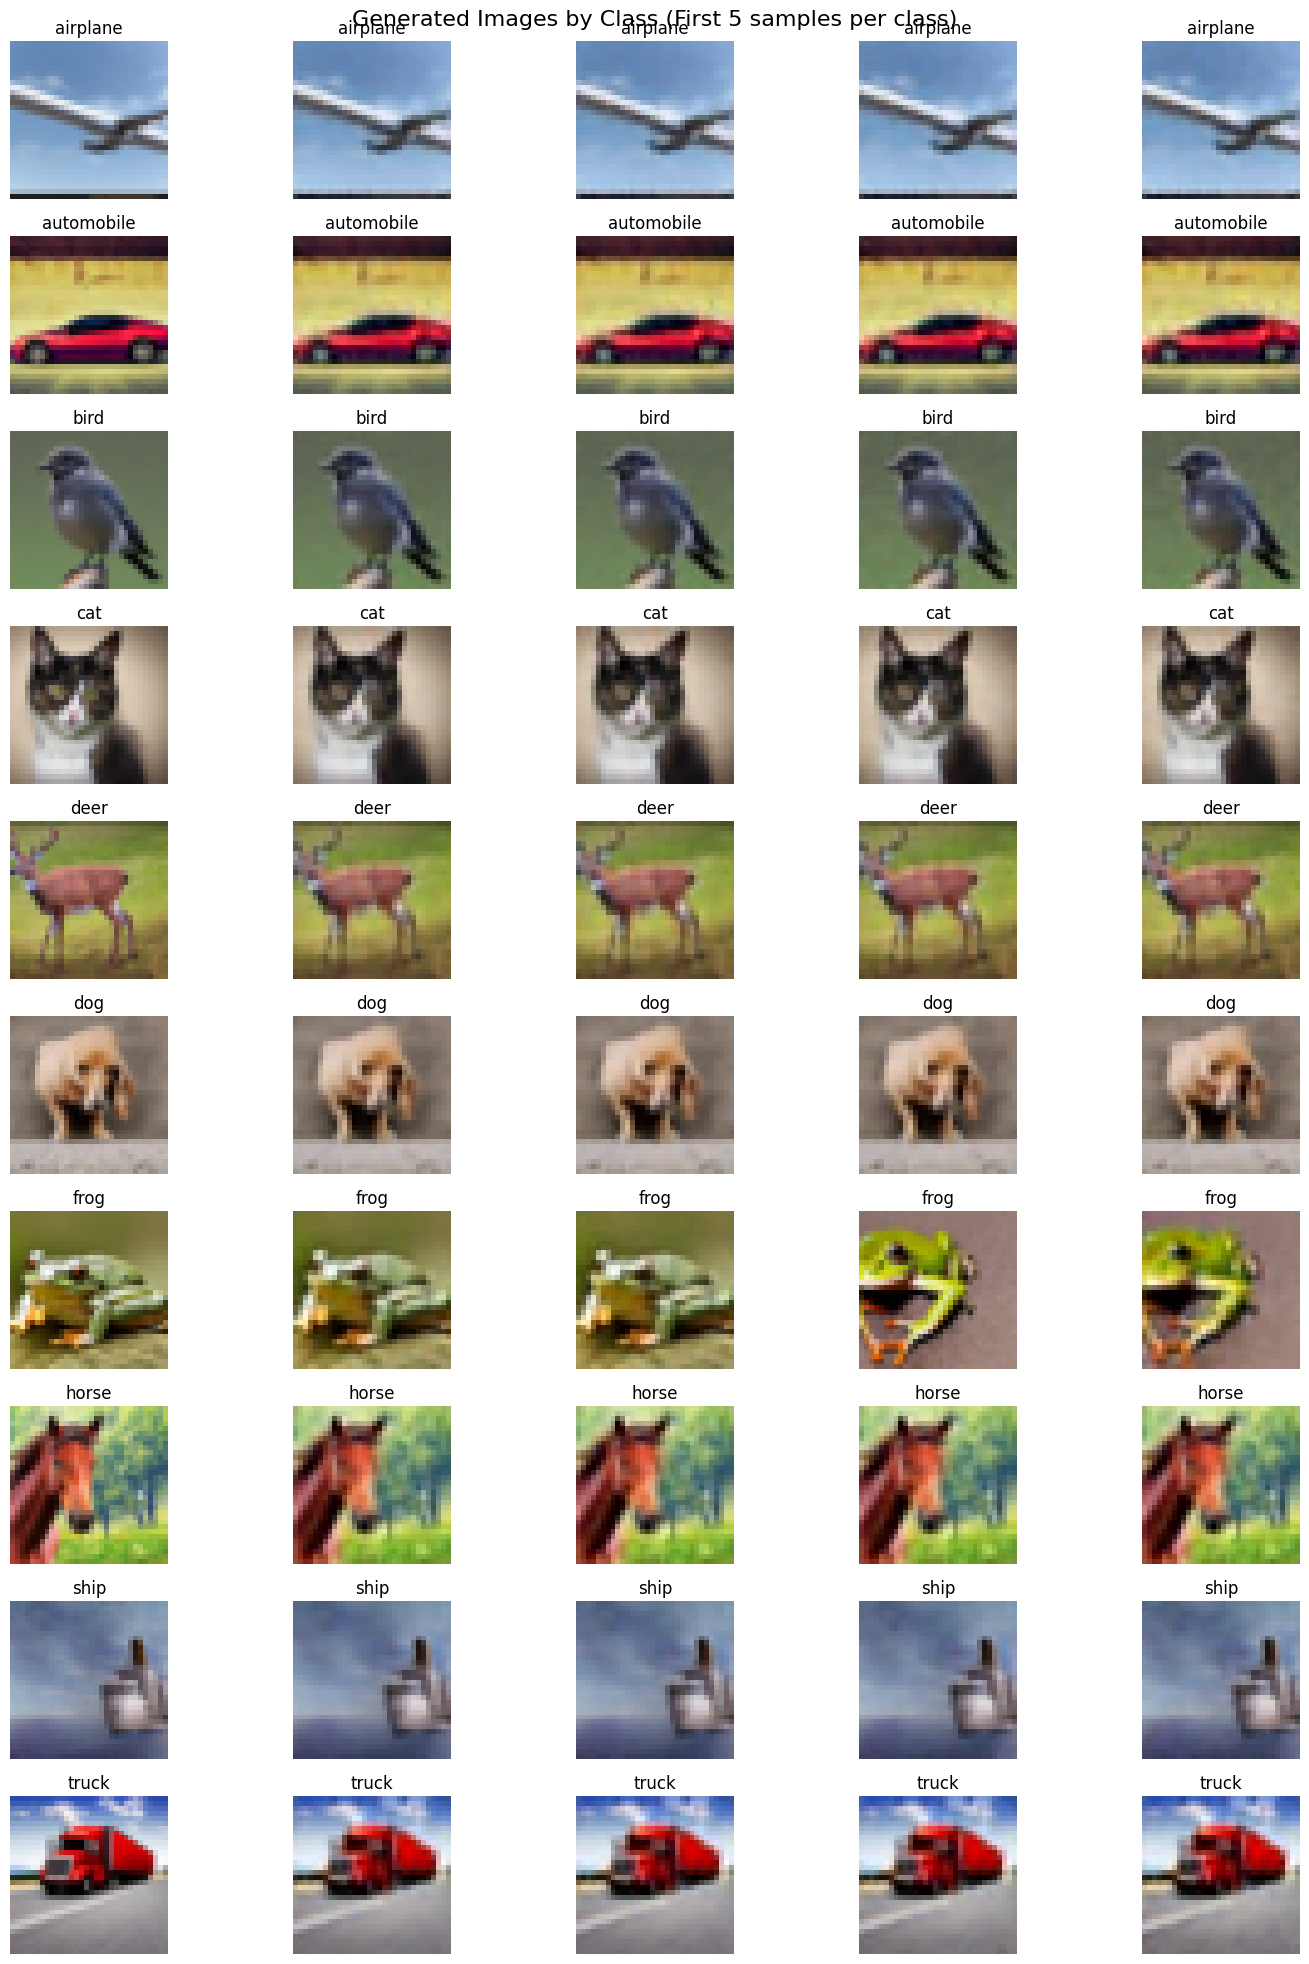

시각화 완료!


In [18]:
# 클래스별로 이미지 시각화 (각 클래스마다 처음 5개)
fig, axes = plt.subplots(10, 5, figsize=(15, 20))
fig.suptitle('Generated Images by Class (First 5 samples per class)', fontsize=16)

class_sample_count = {i: 0 for i in range(15)}

for idx, (img, label) in enumerate(zip(data, labels)):
    label_val = label.item() if hasattr(label, 'item') else int(label)
    
    if class_sample_count[label_val] < 15:
        row = label_val
        col = class_sample_count[label_val]//3
        
        # 이미지 정규화 제거 (범위를 0-1로 변환)
        img_np = img.cpu().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))  # CHW -> HWC
        
        # 정규화된 이미지를 원래 범위로 복원
        # Normalize((0,0,0),(1,1,1))이므로, denormalize 필요 없음 (이미 0-1 범위)
        img_np = np.clip(img_np, 0, 1)
        
        axes[row, col].imshow(img_np)
        axes[row, col].set_title(f'{CIFAR10_CLASSES[label_val]}')
        axes[row, col].axis('off')
        
        class_sample_count[label_val] += 3

plt.tight_layout()
plt.show()

print("시각화 완료!")

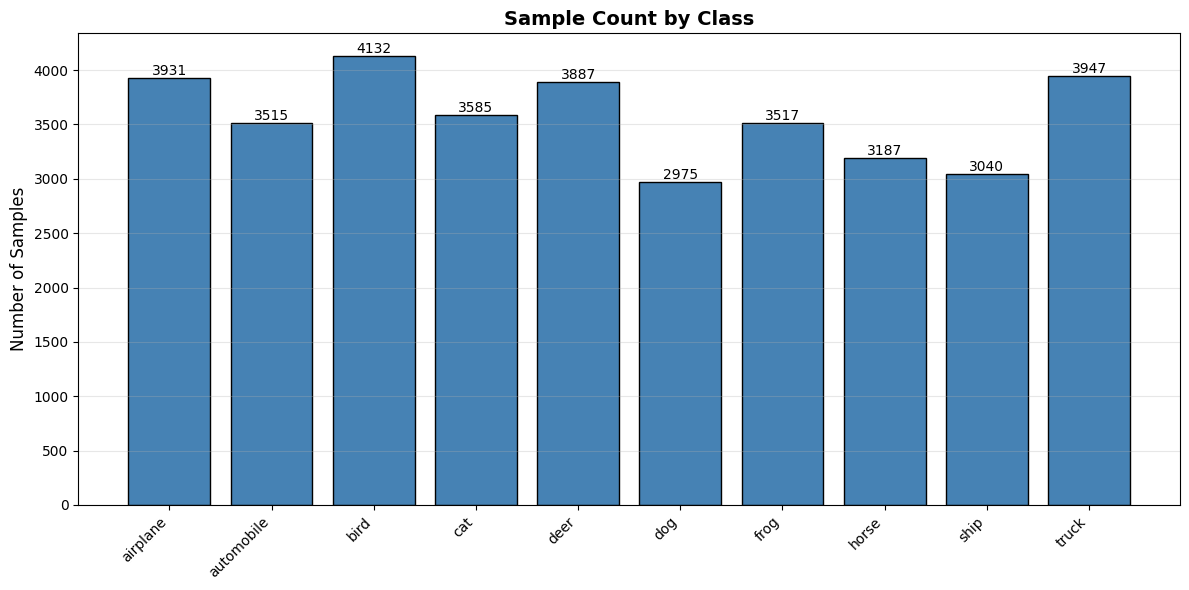

In [19]:
# 클래스별 히스토그램
fig, ax = plt.subplots(figsize=(12, 6))
class_names = CIFAR10_CLASSES[:len(class_counts)]
class_ids = sorted(class_counts.keys())
counts = [class_counts[cid] for cid in class_ids]

bars = ax.bar(class_names, counts, color='steelblue', edgecolor='black')
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Sample Count by Class', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 각 bar에 값 표시
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
# 다양한 파일에서 데이터 비교 (augmentation 여부, 모델 종류)
import os

files_to_check = [
    'cifar10/generated_data.pt',
    'cifar10/generated_data_vgg16_False.pt',
    'cifar10/generated_data_vgg16_True.pt',
    'cifar10/generated_data_resnet18_False.pt',
    'cifar10/generated_data_resnet18_True.pt',
]

print("Available generated data files:")
for file_path in files_to_check:
    if Path(file_path).exists():
        data = torch.load(file_path, map_location='cpu')
        labels = torch.load(file_path.replace('_data', '_label'), map_location='cpu')
        
        # 원-핫 인코딩된 라벨을 클래스 인덱스로 변환
        if labels.dim() > 1 and labels.shape[1] > 1:
            labels = torch.argmax(labels, dim=1)
        
        print(f"✓ {file_path:45} -> Data: {data.shape}, Labels: {labels.shape}")
    else:
        print(f"✗ {file_path:45} (not found)")

Available generated data files:
✗ cifar10/generated_data.pt                     (not found)
✗ cifar10/generated_data_vgg16_False.pt         (not found)
✗ cifar10/generated_data_vgg16_True.pt          (not found)
✓ cifar10/generated_data_resnet18_False.pt      -> Data: torch.Size([6899, 3, 32, 32]), Labels: torch.Size([6899])
✗ cifar10/generated_data_resnet18_True.pt       (not found)


Difference shape: (28, 28, 3), dtype: uint8


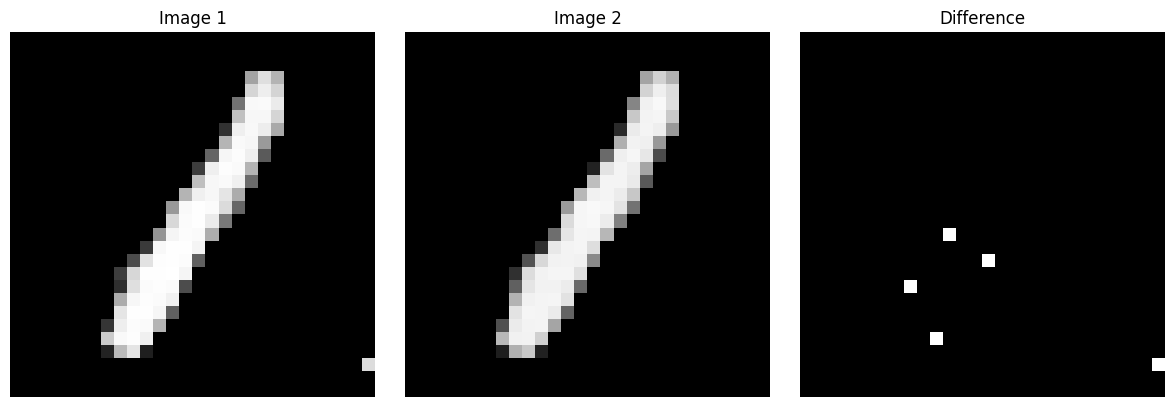

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def img_difference(img1, img2):
    """두 이미지 간의 차이를 시각화하는 함수"""
    # 이미지를 numpy 배열로 변환
    img1_np = img1.cpu().numpy()
    img2_np = img2.cpu().numpy()
    
    # CHW -> HWC 변환
    img1_np = np.transpose(img1_np, (1, 2, 0))
    img2_np = np.transpose(img2_np, (1, 2, 0))
    
    # 정규화 제거 (0-1 범위로 변환)
    img1_np = np.clip(img1_np, 0, 1)
    img2_np = np.clip(img2_np, 0, 1)
    
    # 차이 계산
    diff = cv2.absdiff((img1_np * 255).astype(np.uint8), (img2_np * 255).astype(np.uint8))
    print(f"Difference shape: {diff.shape}, dtype: {diff.dtype}")
    # 차이 강조
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, diff_thresh = cv2.threshold(diff_gray, 30, 255, cv2.THRESH_BINARY)
    
    # 시각화
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(img1_np)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Image 2')
    plt.imshow(img2_np)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Difference')
    plt.imshow(diff_thresh, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

img_file1 = './mnist/generated_data_GAN/1/0100.png'
img_file2 = './mnist/generated_data_GAN/1/0103.png'
img1 = cv2.imread(img_file1)
img2 = cv2.imread(img_file2)
img1_tensor = torch.from_numpy(img1).permute(2, 0, 1).float() / 255.0
img2_tensor = torch.from_numpy(img2).permute(2, 0, 1).float() / 255.0
img_difference(img1_tensor, img2_tensor)